In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [2]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
df.shape

(8807, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
df.isnull().sum().sort_values(ascending=False)

director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
description        0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [19]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_18928\2154983322.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_countries.index, x=top_countries.values, palette='viridis')


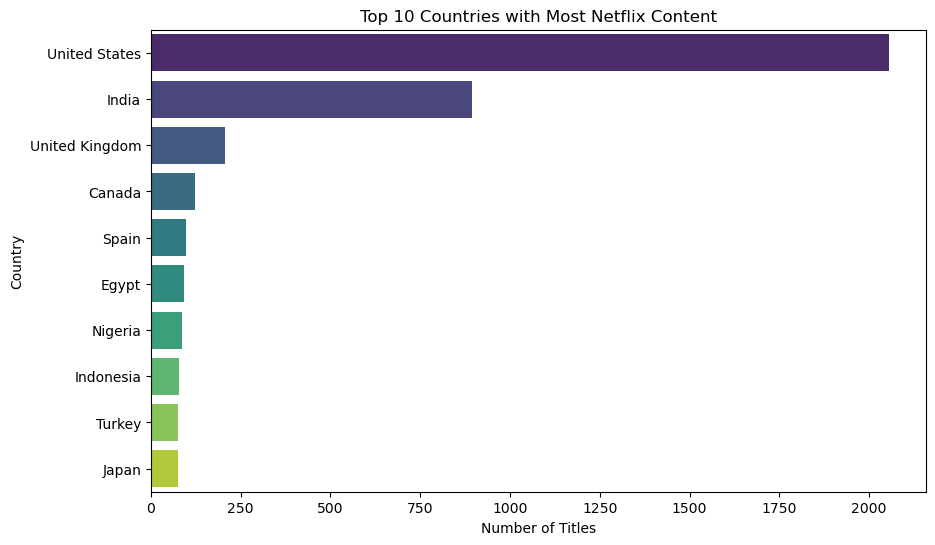

In [21]:

top_countries = df['country'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(y=top_countries.index, x=top_countries.values, palette='viridis')
plt.title('Top 10 Countries with Most Netflix Content')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()


C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_18928\1709259329.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Genre', x='Count', data=genres_df, palette='magma')


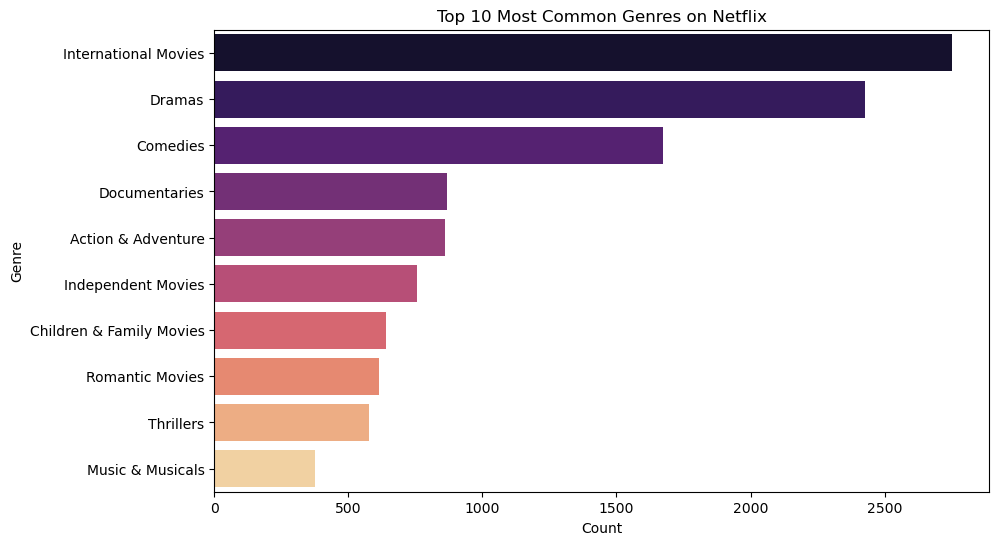

In [22]:

from collections import Counter

genre_counter = Counter()
for i in df['listed_in'].dropna():
    genres = i.split(', ')
    genre_counter.update(genres)

top_genres = genre_counter.most_common(10)
genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

plt.figure(figsize=(10,6))
sns.barplot(y='Genre', x='Count', data=genres_df, palette='magma')
plt.title('Top 10 Most Common Genres on Netflix')
plt.show()


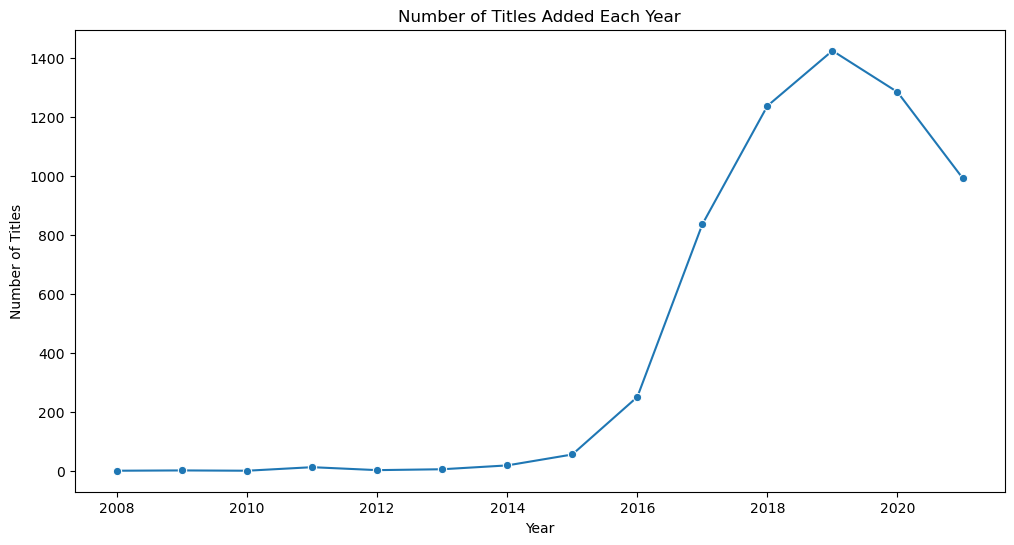

In [23]:

yearly_counts = df['year_added'].value_counts().sort_index()
plt.figure(figsize=(12,6))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o')
plt.title('Number of Titles Added Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.show()


C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_18928\2946630905.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_directors.index, x=top_directors.values, palette='Set3')


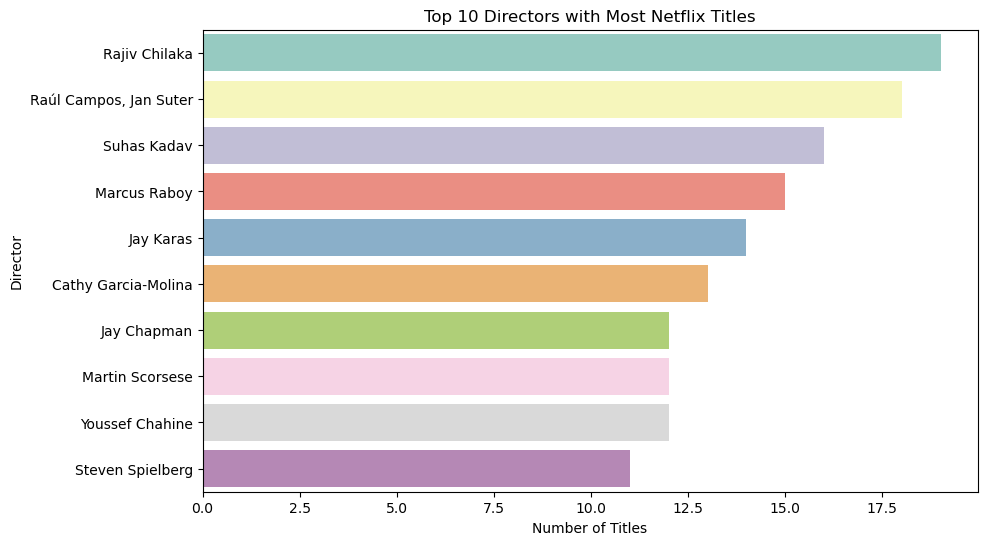

In [24]:

top_directors = df['director'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(y=top_directors.index, x=top_directors.values, palette='Set3')
plt.title('Top 10 Directors with Most Netflix Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Director')
plt.show()


In [8]:
df = df.dropna(subset=['listed_in', 'duration', 'rating'])


In [9]:
df = df[df['type'] == 'Movie']

In [10]:
df['duration'] = df['duration'].str.replace(' min', '').astype(int)

In [11]:
df['genre_list'] = df['listed_in'].apply(lambda x: [i.strip() for i in x.split(',')])

In [12]:
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_, index=df.index)

In [13]:
rating_map = {rating: idx for idx, rating in enumerate(df['rating'].unique())}
df['rating_encoded'] = df['rating'].map(rating_map)


In [14]:
features = pd.concat([df[['duration', 'rating_encoded']], genre_encoded], axis=1)

In [15]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [16]:
# Elbow Method to Find Optimal K
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

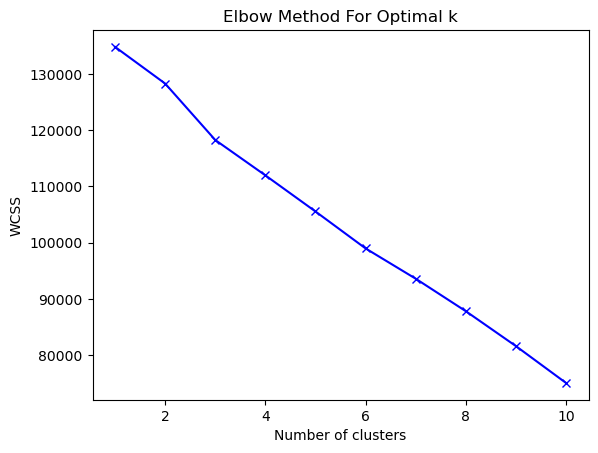

In [17]:
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

In [19]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
df['pca1'] = pca_components[:, 0]
df['pca2'] = pca_components[:, 1]


In [20]:
# Step 13: Analyze top genres per cluster
for i in range(4):
    print(f"\nTop genres in Cluster {i}:")
    cluster_indices = df[df['cluster'] == i].index
    cluster_genres = genre_encoded.loc[cluster_indices]
    top_genres = cluster_genres.sum().sort_values(ascending=False).head(5)
    print(top_genres)



Top genres in Cluster 0:
Music & Musicals        375
International Movies    184
Documentaries           126
Comedies                 91
Dramas                   87
dtype: int64

Top genres in Cluster 1:
International Movies    2303
Dramas                  2254
Comedies                1296
Action & Adventure       820
Independent Movies       743
dtype: int64

Top genres in Cluster 2:
Documentaries               739
Children & Family Movies    582
Stand-Up Comedy             336
Comedies                    287
International Movies        265
dtype: int64

Top genres in Cluster 3:
Movies                53
Action & Adventure     0
Anime Features         0
Stand-Up Comedy        0
Sports Movies          0
dtype: int64


In [21]:
# Step 14: Summary statistics per cluster
print("\nAverage duration and rating by cluster:")
summary = df.groupby('cluster')[['duration', 'rating_encoded']].mean()
print(summary)



Average duration and rating by cluster:
           duration  rating_encoded
cluster                            
0        106.125333        3.440000
1        109.468080        3.242643
2         76.347156        3.529028
3         45.641509        4.584906


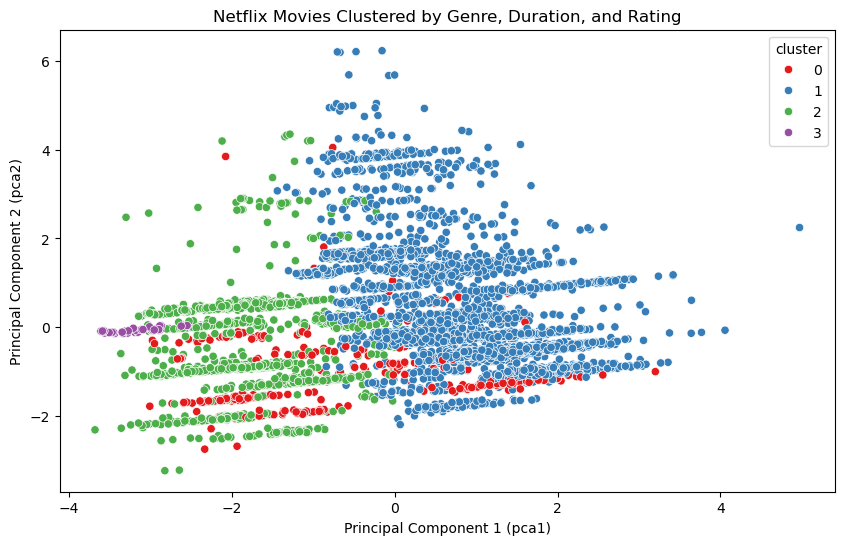

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='Set1')
plt.title('Netflix Movies Clustered by Genre, Duration, and Rating')
plt.xlabel('Principal Component 1 (pca1)')
plt.ylabel('Principal Component 2 (pca2)')
plt.show()

In [23]:
# Optional: View Sample Titles per Cluster with aligned formatting
for i in range(4):
    print(f"\nCluster {i} Sample Titles")
    print("="*80)
    sample = df[df['cluster'] == i][['title', 'rating', 'listed_in', 'duration']].head(5)
    print(sample.rename(columns={
        'title': 'Title',
        'rating': 'Rating',
        'listed_in': 'Genre',
        'duration': 'Duration (min)'
    }).to_string(index=False))
    print("="*80)



Cluster 0 Sample Titles
                                                Title Rating                                            Genre  Duration (min)
                                       Minsara Kanavu  TV-PG Comedies, International Movies, Music & Musicals             147
If I Leave Here Tomorrow: A Film About Lynyrd Skynyrd  TV-MA                  Documentaries, Music & Musicals              97
                           Barbie Big City Big Dreams   TV-Y       Children & Family Movies, Music & Musicals              63
                                        House Party 2      R          Comedies, Cult Movies, Music & Musicals              94
                                        House Party 3      R                       Comedies, Music & Musicals              94

Cluster 1 Sample Titles
          Title Rating                                            Genre  Duration (min)
        Sankofa  TV-MA Dramas, Independent Movies, International Movies             125
   The Starling  P

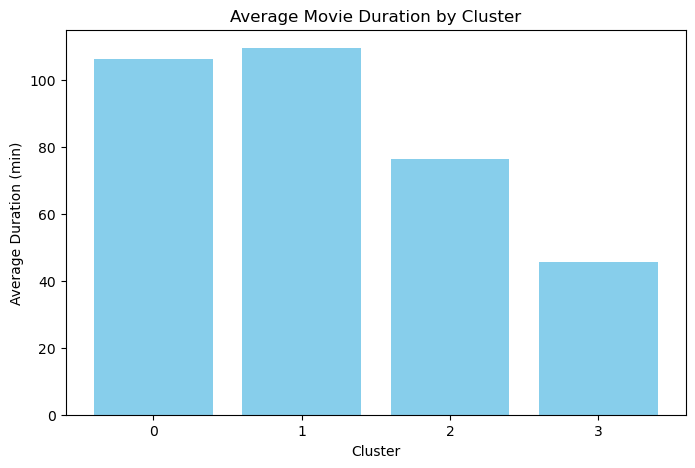

In [25]:
plt.figure(figsize=(8, 5))
avg_duration = df.groupby('cluster')['duration'].mean()
plt.bar(avg_duration.index, avg_duration.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Average Duration (min)')
plt.title('Average Movie Duration by Cluster')
plt.xticks(avg_duration.index)
plt.show()

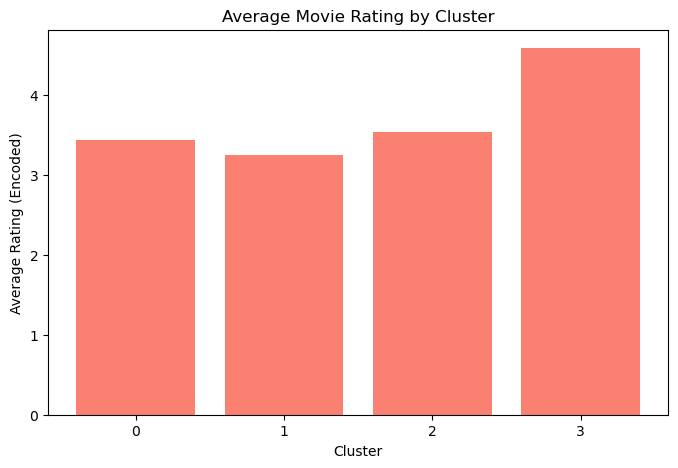

In [26]:
plt.figure(figsize=(8, 5))
avg_rating = df.groupby('cluster')['rating_encoded'].mean()
plt.bar(avg_rating.index, avg_rating.values, color='salmon')
plt.xlabel('Cluster')
plt.ylabel('Average Rating (Encoded)')
plt.title('Average Movie Rating by Cluster')
plt.xticks(avg_rating.index)
plt.show()


In [27]:
import collections
for i in range(4):
    genres = df[df['cluster'] == i]['genre_list'].sum()
    top_genres = collections.Counter(genres).most_common(3)
    print(f"Top 3 Genres in Cluster {i}: {top_genres}")


Top 3 Genres in Cluster 0: [('Music & Musicals', 375), ('International Movies', 184), ('Documentaries', 126)]
Top 3 Genres in Cluster 1: [('International Movies', 2303), ('Dramas', 2254), ('Comedies', 1296)]
Top 3 Genres in Cluster 2: [('Documentaries', 739), ('Children & Family Movies', 582), ('Stand-Up Comedy', 336)]
Top 3 Genres in Cluster 3: [('Movies', 53)]
